# Bioinformatics Project 2025 - Motif CNN & GO Prediction

**Course:** GRS34806 Deep Learning

**Authors:** Berkay Helvaci & Maurits Naber

**Date:**



## Importing Libraries

Clean the code last time! also the redundant libraries.

In [2]:
import os
import sys
from pathlib import Path

! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git -q
! git clone https://github.com/maussn/GRS34806-project.git -q
os.chdir(Path('grs34806-deep-learning-project-data'))

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_fscore_support
from datetime import datetime
import sys
import os
from pathlib import Path
import random
import seaborn as sns

## Data I/O & Tokenisation

In [4]:
# 1. read() --------------------------------------------------------------------
def read(seqfile: str, posfile: str) -> tuple[list, list]:
    """Read file with sequences and file with positive cases into lists.

    :param seqfile: file with sequences
    :type seqfile: str
    :param posfile: file with positive cases (annotated with function)
    :type posfile: str
    :return: two lists, first with sequences and second with boolean labels
    :rtype: tuple[list, list]
    """
    idlist = []
    datalist = []
    labellist = []
    with open(seqfile, 'r') as f:
        for line in f.readlines():
            line = line.rstrip().split('\t')
            idlist.append(line[0])
            datalist.append(line[1])
            labellist.append(False)
    with open(posfile, 'r') as f:
        for line in f.readlines():
            id = line.rstrip()
            try:
                i = idlist.index(id)
                labellist[i] = True
            except ValueError:
                continue
    return datalist, labellist


# 2. split_labelled() ----------------------------------------------------------
def split_labelled(datalist: list, labellist: list):
    """Return two separate sequence lists: positives & negatives."""
    pos_datalist = []
    neg_datalist = []
    for i, label in enumerate(labellist):
        if label:
            pos_datalist.append(datalist[i])
        else:
            neg_datalist.append(datalist[i])
    return pos_datalist, neg_datalist


# 3. remove_sequences() -----
def remove_sequences(datalist: list, fraction=0.5):
    """Randomly keeps half of the list"""
    random.shuffle(datalist)
    keep = round(len(datalist) * fraction)
    return datalist[:keep]


# 4. fuse_sequence_lists() ------------
def fuse_sequence_lists(pos_datalist: list, neg_datalist: list):
    """Merge postives and negetaves into one list + label"""
    pos_labels = [True for _ in pos_datalist]
    neg_labels = [False for _ in neg_datalist]
    datalist = pos_datalist + neg_datalist
    labellist = pos_labels + neg_labels
    return datalist, labellist


# 5. generate_train_test() --------
def generate_train_test(datalist: list, labellist: list, fraction: float=0.8):
    """Split up dataset in training set and test set

    :param datalist: list with sequences
    :type datalist: list
    :param labellist: list with labels
    :type labellist: list
    :param ratio: fraction to be added to the training set, remainder is added to the test set, defaults to 0.8
    :type ratio: float, optional
    :return: four lists, first two the training data and labels, second two the test data and labels
    :rtype: tuple[list, list, list, list]
    """
    c = list(zip(datalist, labellist))
    random.shuffle(c)
    datalist[:], labellist[:] = zip(*c)
    i = round(len(datalist) * fraction)
    traindatalist = datalist[:i]
    trainlabellist = labellist[:i]
    testdatalist = datalist[i:]
    testlabellist = labellist[i:]
    return traindatalist, trainlabellist,testdatalist,testlabellist


# 6. Tokenisation & Padding --------
def tokenize(data: list, map2num: dict, non_aa_num: int=20) -> list:
    """Tokenize all sequences in a list

    :param data: list of sequences to tokenize
    :type data: list
    :param map2num: ammino acid -> integer token mapping
    :type map2num: dict
    :param non_aa_num: token for non amino acid characters, defaults to 20
    :type non_aa_num: int, optional
    :return: list of tokenized sequences
    :rtype: list
    """
    seq = []
    for count, i in enumerate(data):
        seq.append([map2num.get(j,non_aa_num) for j in list(i)])
    return seq


def truncate_pad(line: list, num_steps: int, padding_token: int) -> list:
    """Truncate or pad a tokenized sequence

    :param line: tokenized sequence
    :type line: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param padding_token: token to be used for padding
    :type padding_token: int
    :return: truncated/padded sequence
    :rtype: list
    """
    if len(line) > num_steps:
        return line[:num_steps] # Truncate
    return line + [padding_token] * (num_steps - len(line)) # Pad


def build_seq_array(lines: list, num_steps: int, non_aa_num: int=20) -> torch.tensor:
    """Truncate or pad tokenized sequences and convert to tensor

    :param lines: tokenized sequences
    :type lines: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param non_aa_num: token for padding, defaults to 20
    :type non_aa_num: int, optional
    :return: tensor with truncated/padded tokenized sequences
    :rtype: torch.tensor
    """
    return torch.tensor([truncate_pad(l, num_steps, non_aa_num) for l in lines], dtype=torch.long)


# 7. load_array() & load_data()
def load_array(data_arrays: tuple[torch.tensor, torch.tensor], batch_size: int, is_train: bool=True) -> torch.utils.data.DataLoader:
    """Construct a PyTorch data iterator.

    Taken from d2l package"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)


def load_data(batch_size: int, num_steps: int, dataset: tuple[list, list]) -> torch.utils.data.DataLoader:
    """Tokenize sequence/label dataset and load into dataloader.

    :param batch_size: size of each batch
    :type batch_size: int
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param dataset: first list contains sequences, second labels
    :type dataset: tuple[list, list]
    :return: torch dataloader which gives a tensor of sequences in a batch and a tensor with their labels
    :rtype: torch.utils.data.DataLoader
    """
    mapaa2num = {aa: i for (i, aa) in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
    seq,lab = dataset
    seq = tokenize(seq, mapaa2num)
    seq_array = build_seq_array(seq, num_steps)
    data_arrays = (seq_array, torch.tensor(lab, dtype=torch.long))
    data_iter = load_array(data_arrays, batch_size)
    return data_iter

## Dataset selector





In [5]:
# For the GO dataset
REMOVE = "neg"                   # None | "neg" | "pos"

seq_path  = "expr5Tseq_filtGO_100-1000.lis"
pos_path  = "GO_3A0005739.annotprot"
datalist, labellist = read(seq_path, pos_path)

# Removing half dataset
if REMOVE is not None:
    pos_datalist, neg_datalist = split_labelled(datalist, labellist)
    if REMOVE == "neg":
        neg_datalist = remove_sequences(neg_datalist, 0.5)
    elif REMOVE == "pos":
        pos_datalist = remove_sequences(pos_datalist, 0.5)
    datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

In [6]:
# For the synthetic dataset
dataset_id = "len100_200_n1000"
REMOVE = None                   # None | "neg" | "pos"

seq_path  = f"{dataset_id}.seq"
pos_path  = f"{dataset_id}.pos"
datalist, labellist = read(seq_path, pos_path)

# Removing half dataset
if REMOVE is not None:
    pos_datalist, neg_datalist = split_labelled(datalist, labellist)
    if REMOVE == "neg":
        neg_datalist = remove_sequences(neg_datalist, 0.8)
    elif REMOVE == "pos":
        pos_datalist = remove_sequences(pos_datalist, 0.8)
    datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

## Data Loader

In [7]:
batch_size = 10
num_steps = 1000 # max sequence length

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

print("batch shape  :", next(iter(train_iter))[0].shape)
print("labels shape :", next(iter(train_iter))[1].shape)

batch shape  : torch.Size([10, 1000])
labels shape : torch.Size([10])


## Training / Evaluation

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
        nn.init.xavier_uniform_(layer.weight)

class Trainer:
    def __init__(self, model, loss_fn, optimizer, device='cuda'):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.columns = [
            'epoch',
            'train_accuracy',
            'train_precision',
            'train_recall',
            'train_fscore',
            'train_loss',
            'test_accuracy',
            'test_precision',
            'test_recall',
            'test_fscore',
            'test_loss'
        ]
        self.df = pd.DataFrame(columns=self.columns)


    # One training epoch -------------------------------------------------------
    def _train_one_epoch(self, train_iter):
        result_loss = 0
        tpos = fpos = tneg = fneg = 0
        self.model.train(True)

        for i, (inputs, labels) in enumerate(train_iter):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()
            result_loss += loss.item()

            # Confusion matrix calculation
            for j, l in enumerate(labels):
                o = outputs[j].tolist().index(max(outputs[j]))
                l = l.item()
                if o == 1 and l == 1:
                    tpos += 1
                elif o == 1 and l == 0:
                    fpos += 1
                elif o == 0 and l == 0:
                    tneg += 1
                elif o == 0 and l == 1:
                    fneg += 1
                else:
                    raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')

        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0

        return accuracy, precision, recall, fscore, result_loss / (i+1)

    # Evaluation epoch ---------------------------------------------------------
    def _test_one_epoch(self, test_iter):
        result_loss = 0
        tpos = fpos = tneg = fneg = 0
        self.model.eval()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_iter, start=1):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.loss_fn(input=outputs, target=labels)
                result_loss += loss.item()

                # Confusion matrix calculation
                for j, l in enumerate(labels):
                    o = outputs[j].tolist().index(max(outputs[j]))
                    l = l.item()
                    if o == 1 and l == 1:
                        tpos += 1
                    elif o == 1 and l == 0:
                        fpos += 1
                    elif o == 0 and l == 0:
                        tneg += 1
                    elif o == 0 and l == 1:
                        fneg += 1
                    else:
                        raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')

        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0

        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _load_into_dict(self, epoch, train_stats, test_stats):
        row = [epoch] + list(train_stats) + list(test_stats)
        row = pd.DataFrame(row, index=self.columns).T
        self.df = pd.concat([self.df, row], axis=0)


    def train(self, epochs, train_iter, test_iter):

        for epoch in range(epochs):
            train_stats = self._train_one_epoch(train_iter)

            test_stats = self._test_one_epoch(test_iter)
            self._load_into_dict(epoch, train_stats, test_stats)
            print(f"[epoch {epoch:02d}] "
                  f"train-loss={train_stats[-1]:.4f} | "
                  f"test-loss={test_stats[-1]:.4f} | "
                  f"train-acc={train_stats[0]:.4f} | "
                  f"test-acc={test_stats[0]:.4f} | "
                  f"P={test_stats[1]:.4f} | R={test_stats[2]:.4f} | F1={test_stats[3]:.4f}")

        return self.df

In [10]:
class BerryCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, vocab_size: int = 21,
                 dropout_rate = 0, conv_channels: int = 128,
                 use_bias: bool = False):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )


        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=2, bias=use_bias)  # binary classification
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        return self.fc(x)


## Training the Model

In [11]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'dropout_rate': [0, 0.3],
    'lr': [0.01, 0.001],
    'momentum': [0, 0.5],
    'conv_channels': [64, 128]
}

grid = list(ParameterGrid(param_grid))

best_acc = 0
best_params = None

df = None

for params in grid:
    print("Current hyper-parameters:", params)
    model = BerryCNN1D(
        vocab_size=21,
        dropout_rate=params['dropout_rate'],
        conv_channels=params['conv_channels']
    )
    model.apply(init_weights)

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=params['lr'],
        momentum=params['momentum']
    )

    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, loss_fn, optimizer, device)

    out_df = trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

    for p in params.keys():
        out_df[p] = params[p]

    acc = out_df['test_accuracy'].max()

    if acc >= best_acc:
        best_acc = []
        best_acc = acc
        best_params = params
        print(f"New best accuracy {best_acc:.4f} with {best_params} \n")

    if type(df) != pd.DataFrame:
        df = out_df
    else:
        df = pd.concat([df, out_df], axis=0)

print("Best hyper‑parameters found:", best_params)

Current hyper-parameters: {'conv_channels': 64, 'dropout_rate': 0, 'lr': 0.01, 'momentum': 0}


<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6706 | test-loss=0.5830 | train-acc=0.5900 | test-acc=0.7600 | P=0.8889 | R=0.6486 | F1=0.7500
[epoch 01] train-loss=0.4676 | test-loss=0.2590 | train-acc=0.8562 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.1479 | test-loss=0.0759 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0536 | test-loss=0.0363 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0283 | test-loss=0.0217 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0185 | test-loss=0.0152 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0133 | test-loss=0.0113 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0102 | test-loss=0.0089 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0082 | test-loss=0.0073 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.4736 | test-loss=0.1145 | train-acc=0.7800 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0547 | test-loss=0.0247 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0178 | test-loss=0.0122 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0100 | test-loss=0.0076 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0068 | test-loss=0.0056 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0051 | test-loss=0.0043 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0040 | test-loss=0.0035 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0033 | test-loss=0.0029 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0028 | test-loss=0.0025 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7100 | test-loss=0.6608 | train-acc=0.4900 | test-acc=0.5400 | P=0.5683 | R=0.7117 | F1=0.6320
[epoch 01] train-loss=0.6932 | test-loss=0.6641 | train-acc=0.5125 | test-acc=0.4900 | P=0.5616 | R=0.3694 | F1=0.4457
[epoch 02] train-loss=0.6866 | test-loss=0.6664 | train-acc=0.5337 | test-acc=0.4850 | P=0.6053 | R=0.2072 | F1=0.3087
[epoch 03] train-loss=0.6795 | test-loss=0.6487 | train-acc=0.5687 | test-acc=0.5950 | P=0.6172 | R=0.7117 | F1=0.6611
[epoch 04] train-loss=0.6698 | test-loss=0.6377 | train-acc=0.6100 | test-acc=0.5950 | P=0.6071 | R=0.7658 | F1=0.6773
[epoch 05] train-loss=0.6573 | test-loss=0.6376 | train-acc=0.6713 | test-acc=0.5950 | P=0.7679 | R=0.3874 | F1=0.5150
[epoch 06] train-loss=0.6425 | test-loss=0.6244 | train-acc=0.7225 | test-acc=0.6550 | P=0.8750 | R=0.4414 | F1=0.5868
[epoch 07] train-loss=0.6222 | test-loss=0.5930 | train-acc=0.8013 | test-acc=0.7600 | P=0.7266 | R=0.9099 | F1=0.8080
[epoch 08] train-loss=0.6002 | test-loss=0.5732 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6976 | test-loss=0.6626 | train-acc=0.4925 | test-acc=0.4900 | P=0.5634 | R=0.3604 | F1=0.4396
[epoch 01] train-loss=0.6863 | test-loss=0.6566 | train-acc=0.5587 | test-acc=0.5200 | P=0.6027 | R=0.3964 | F1=0.4783
[epoch 02] train-loss=0.6763 | test-loss=0.6482 | train-acc=0.5962 | test-acc=0.5750 | P=0.6912 | R=0.4234 | F1=0.5251
[epoch 03] train-loss=0.6627 | test-loss=0.6231 | train-acc=0.6425 | test-acc=0.6600 | P=0.6319 | R=0.9279 | F1=0.7518
[epoch 04] train-loss=0.6397 | test-loss=0.6017 | train-acc=0.7488 | test-acc=0.7700 | P=0.8037 | R=0.7748 | F1=0.7890
[epoch 05] train-loss=0.6003 | test-loss=0.5810 | train-acc=0.8450 | test-acc=0.7050 | P=1.0000 | R=0.4685 | F1=0.6380
[epoch 06] train-loss=0.5501 | test-loss=0.4977 | train-acc=0.9137 | test-acc=0.9500 | P=0.9174 | R=1.0000 | F1=0.9569
[epoch 07] train-loss=0.4819 | test-loss=0.4324 | train-acc=0.9825 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.4029 | test-loss=0.3529 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7258 | test-loss=0.6390 | train-acc=0.5038 | test-acc=0.5550 | P=0.8929 | R=0.2252 | F1=0.3597
[epoch 01] train-loss=0.6471 | test-loss=0.4851 | train-acc=0.6212 | test-acc=0.9650 | P=0.9407 | R=1.0000 | F1=0.9694
[epoch 02] train-loss=0.4707 | test-loss=0.2464 | train-acc=0.8113 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.2688 | test-loss=0.1143 | train-acc=0.9450 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.2090 | test-loss=0.0700 | train-acc=0.9500 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.1721 | test-loss=0.0540 | train-acc=0.9600 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.1582 | test-loss=0.0428 | train-acc=0.9550 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.1519 | test-loss=0.0379 | train-acc=0.9425 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.1296 | test-loss=0.0297 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6844 | test-loss=0.3853 | train-acc=0.5663 | test-acc=0.9850 | P=0.9737 | R=1.0000 | F1=0.9867
[epoch 01] train-loss=0.2560 | test-loss=0.0690 | train-acc=0.9275 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0777 | test-loss=0.0202 | train-acc=0.9838 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0508 | test-loss=0.0104 | train-acc=0.9925 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0360 | test-loss=0.0067 | train-acc=0.9938 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0404 | test-loss=0.0075 | train-acc=0.9888 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0175 | test-loss=0.0040 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0196 | test-loss=0.0049 | train-acc=0.9950 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0161 | test-loss=0.0043 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7427 | test-loss=0.6706 | train-acc=0.4988 | test-acc=0.4750 | P=0.5625 | R=0.2432 | F1=0.3396
[epoch 01] train-loss=0.7246 | test-loss=0.6607 | train-acc=0.4750 | test-acc=0.5150 | P=0.5455 | R=0.7568 | F1=0.6340
[epoch 02] train-loss=0.7261 | test-loss=0.6644 | train-acc=0.5100 | test-acc=0.5000 | P=0.5632 | R=0.4414 | F1=0.4949
[epoch 03] train-loss=0.7210 | test-loss=0.6619 | train-acc=0.4888 | test-acc=0.4650 | P=0.5189 | R=0.4955 | F1=0.5069
[epoch 04] train-loss=0.7190 | test-loss=0.6605 | train-acc=0.4738 | test-acc=0.4850 | P=0.5370 | R=0.5225 | F1=0.5297
[epoch 05] train-loss=0.7178 | test-loss=0.6569 | train-acc=0.5088 | test-acc=0.5300 | P=0.5603 | R=0.7117 | F1=0.6270
[epoch 06] train-loss=0.7070 | test-loss=0.6589 | train-acc=0.5150 | test-acc=0.5300 | P=0.5977 | R=0.4685 | F1=0.5253
[epoch 07] train-loss=0.7068 | test-loss=0.6532 | train-acc=0.5100 | test-acc=0.5650 | P=0.5833 | R=0.7568 | F1=0.6588
[epoch 08] train-loss=0.6999 | test-loss=0.6541 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7409 | test-loss=0.6469 | train-acc=0.5150 | test-acc=0.5950 | P=0.6705 | R=0.5315 | F1=0.5930
[epoch 01] train-loss=0.7464 | test-loss=0.6396 | train-acc=0.5075 | test-acc=0.6400 | P=0.7826 | R=0.4865 | F1=0.6000
[epoch 02] train-loss=0.7109 | test-loss=0.6212 | train-acc=0.5625 | test-acc=0.7500 | P=0.8144 | R=0.7117 | F1=0.7596
[epoch 03] train-loss=0.6743 | test-loss=0.5987 | train-acc=0.5925 | test-acc=0.8700 | P=0.9048 | R=0.8559 | F1=0.8796
[epoch 04] train-loss=0.6517 | test-loss=0.5646 | train-acc=0.6262 | test-acc=0.9150 | P=0.8790 | R=0.9820 | F1=0.9277
[epoch 05] train-loss=0.6143 | test-loss=0.5228 | train-acc=0.6713 | test-acc=0.9800 | P=0.9652 | R=1.0000 | F1=0.9823
[epoch 06] train-loss=0.5546 | test-loss=0.4578 | train-acc=0.7388 | test-acc=0.9750 | P=0.9569 | R=1.0000 | F1=0.9780
[epoch 07] train-loss=0.5132 | test-loss=0.3963 | train-acc=0.7588 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.4497 | test-loss=0.3439 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6530 | test-loss=0.4700 | train-acc=0.6212 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.2833 | test-loss=0.1156 | train-acc=0.9812 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0722 | test-loss=0.0420 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0314 | test-loss=0.0233 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0185 | test-loss=0.0149 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0127 | test-loss=0.0109 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0095 | test-loss=0.0084 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0075 | test-loss=0.0067 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0061 | test-loss=0.0056 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6616 | test-loss=0.4021 | train-acc=0.5863 | test-acc=0.9950 | P=0.9911 | R=1.0000 | F1=0.9955
[epoch 01] train-loss=0.1540 | test-loss=0.0440 | train-acc=0.9925 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0246 | test-loss=0.0164 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0117 | test-loss=0.0096 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0075 | test-loss=0.0068 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0053 | test-loss=0.0050 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0041 | test-loss=0.0040 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0033 | test-loss=0.0033 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0028 | test-loss=0.0028 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7329 | test-loss=0.6424 | train-acc=0.5150 | test-acc=0.6300 | P=0.6149 | R=0.8919 | F1=0.7279
[epoch 01] train-loss=0.6831 | test-loss=0.6418 | train-acc=0.5737 | test-acc=0.5950 | P=0.6471 | R=0.5946 | F1=0.6197
[epoch 02] train-loss=0.6771 | test-loss=0.6396 | train-acc=0.6125 | test-acc=0.6500 | P=0.7808 | R=0.5135 | F1=0.6196
[epoch 03] train-loss=0.6696 | test-loss=0.6348 | train-acc=0.6538 | test-acc=0.6900 | P=0.8769 | R=0.5135 | F1=0.6477
[epoch 04] train-loss=0.6615 | test-loss=0.6264 | train-acc=0.6913 | test-acc=0.7250 | P=0.9242 | R=0.5495 | F1=0.6893
[epoch 05] train-loss=0.6488 | test-loss=0.6062 | train-acc=0.7262 | test-acc=0.7700 | P=0.7152 | R=0.9730 | F1=0.8244
[epoch 06] train-loss=0.6352 | test-loss=0.5949 | train-acc=0.8263 | test-acc=0.8750 | P=0.8772 | R=0.9009 | F1=0.8889
[epoch 07] train-loss=0.6154 | test-loss=0.5741 | train-acc=0.8725 | test-acc=0.9050 | P=0.8710 | R=0.9730 | F1=0.9191
[epoch 08] train-loss=0.5921 | test-loss=0.5556 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6978 | test-loss=0.6717 | train-acc=0.5038 | test-acc=0.4200 | P=0.3810 | R=0.0721 | F1=0.1212
[epoch 01] train-loss=0.6902 | test-loss=0.6574 | train-acc=0.5325 | test-acc=0.4850 | P=0.5645 | R=0.3153 | F1=0.4046
[epoch 02] train-loss=0.6737 | test-loss=0.6522 | train-acc=0.6025 | test-acc=0.5000 | P=0.7895 | R=0.1351 | F1=0.2308
[epoch 03] train-loss=0.6514 | test-loss=0.6177 | train-acc=0.6863 | test-acc=0.7800 | P=0.7913 | R=0.8198 | F1=0.8053
[epoch 04] train-loss=0.6195 | test-loss=0.5852 | train-acc=0.8425 | test-acc=0.9150 | P=0.9608 | R=0.8829 | F1=0.9202
[epoch 05] train-loss=0.5717 | test-loss=0.5315 | train-acc=0.9163 | test-acc=0.9850 | P=0.9821 | R=0.9910 | F1=0.9865
[epoch 06] train-loss=0.5051 | test-loss=0.4708 | train-acc=0.9950 | test-acc=0.9950 | P=1.0000 | R=0.9910 | F1=0.9955
[epoch 07] train-loss=0.4249 | test-loss=0.3777 | train-acc=0.9975 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.3370 | test-loss=0.2925 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6672 | test-loss=0.5411 | train-acc=0.5800 | test-acc=0.8900 | P=0.8346 | R=1.0000 | F1=0.9098
[epoch 01] train-loss=0.4747 | test-loss=0.2270 | train-acc=0.8013 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.2237 | test-loss=0.0808 | train-acc=0.9450 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.1277 | test-loss=0.0479 | train-acc=0.9712 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0845 | test-loss=0.0248 | train-acc=0.9838 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0585 | test-loss=0.0250 | train-acc=0.9838 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0453 | test-loss=0.0125 | train-acc=0.9900 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0327 | test-loss=0.0095 | train-acc=0.9950 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0300 | test-loss=0.0096 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6266 | test-loss=0.2355 | train-acc=0.6438 | test-acc=0.9950 | P=0.9911 | R=1.0000 | F1=0.9955
[epoch 01] train-loss=0.1873 | test-loss=0.0406 | train-acc=0.9463 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0622 | test-loss=0.0132 | train-acc=0.9862 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0278 | test-loss=0.0049 | train-acc=0.9962 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0221 | test-loss=0.0039 | train-acc=0.9962 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0148 | test-loss=0.0040 | train-acc=0.9950 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0127 | test-loss=0.0032 | train-acc=0.9975 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0103 | test-loss=0.0076 | train-acc=0.9988 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0060 | test-loss=0.0017 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7627 | test-loss=0.6818 | train-acc=0.4900 | test-acc=0.4450 | P=0.5000 | R=0.0090 | F1=0.0177
[epoch 01] train-loss=0.7321 | test-loss=0.6683 | train-acc=0.4938 | test-acc=0.4750 | P=0.5682 | R=0.2252 | F1=0.3226
[epoch 02] train-loss=0.7140 | test-loss=0.6651 | train-acc=0.5150 | test-acc=0.5050 | P=0.6111 | R=0.2973 | F1=0.4000
[epoch 03] train-loss=0.7179 | test-loss=0.6526 | train-acc=0.5062 | test-acc=0.5650 | P=0.5606 | R=1.0000 | F1=0.7184
[epoch 04] train-loss=0.7176 | test-loss=0.6671 | train-acc=0.5050 | test-acc=0.4800 | P=0.8182 | R=0.0811 | F1=0.1475
[epoch 05] train-loss=0.7061 | test-loss=0.6588 | train-acc=0.5275 | test-acc=0.5250 | P=0.7000 | R=0.2523 | F1=0.3709
[epoch 06] train-loss=0.7113 | test-loss=0.6610 | train-acc=0.5100 | test-acc=0.4950 | P=0.9167 | R=0.0991 | F1=0.1789
[epoch 07] train-loss=0.6904 | test-loss=0.6403 | train-acc=0.5613 | test-acc=0.6350 | P=0.6234 | R=0.8649 | F1=0.7245
[epoch 08] train-loss=0.6866 | test-loss=0.6301 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7365 | test-loss=0.6534 | train-acc=0.4963 | test-acc=0.5700 | P=0.5776 | R=0.8378 | F1=0.6838
[epoch 01] train-loss=0.7160 | test-loss=0.6558 | train-acc=0.5138 | test-acc=0.5150 | P=0.5614 | R=0.5766 | F1=0.5689
[epoch 02] train-loss=0.7089 | test-loss=0.6752 | train-acc=0.5262 | test-acc=0.4450 | P=0.5000 | R=0.0180 | F1=0.0348
[epoch 03] train-loss=0.7002 | test-loss=0.6584 | train-acc=0.5437 | test-acc=0.5150 | P=0.6167 | R=0.3333 | F1=0.4327
[epoch 04] train-loss=0.6985 | test-loss=0.6527 | train-acc=0.5300 | test-acc=0.5550 | P=0.5887 | R=0.6577 | F1=0.6213
[epoch 05] train-loss=0.7013 | test-loss=0.6519 | train-acc=0.5325 | test-acc=0.5550 | P=0.6170 | R=0.5225 | F1=0.5659
[epoch 06] train-loss=0.6915 | test-loss=0.6522 | train-acc=0.5350 | test-acc=0.5550 | P=0.6833 | R=0.3694 | F1=0.4795
[epoch 07] train-loss=0.6857 | test-loss=0.6388 | train-acc=0.5463 | test-acc=0.6400 | P=0.6168 | R=0.9279 | F1=0.7410
[epoch 08] train-loss=0.6759 | test-loss=0.6344 

In [13]:
df.to_csv('hyperparameter_grid.csv')

In [ ]:
def plot()

Verander bovenstaande gegevens in een pandas dataframe



len200_500_n5000nr4 = Best hyper‑parameters found: {'conv_channels': 64, 'dropout_rate': 0, 'lr': 0.01, 'momentum': 0}

# Multi-label prediction

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import sys
import os
from pathlib import Path
import random
import seaborn as sns
import pandas as pd


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from functools import total_ordering
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
        nn.init.xavier_uniform_(layer.weight)

# Load data multiple labels

In [5]:
def read_multiple_pos(seqfile: str, posfiles: list[str]) -> tuple[list, list]:
    """Read file with sequences and file with positive cases into lists.

    :param seqfile: file with sequences
    :type seqfile: str
    :param posfiles: files with positive cases (annotated with function)
    :type posfile: str
    :return: two lists, first with sequences and second with integer labels
    :rtype: tuple[list, list]
    """
    idlist = []
    datalist = []
    labellist = []
    with open(seqfile, 'r') as f:
        for line in f.readlines():
            line = line.rstrip().split('\t')
            idlist.append(line[0])
            datalist.append(line[1])
            labellist.append([0 for _ in posfiles])
    for l, posfile in enumerate(posfiles):
        with open(posfile, 'r') as f:
            for line in f.readlines():
                id = line.rstrip()
                try:
                    i = idlist.index(id)
                    # if labellist[i] != 0:
                    #     raise Exception(f'Sequence with multiple labels. {id = }, {labellist[i] = }, {l = }')
                    labellist[i][l] = 1
                except ValueError:
                    continue
    return datalist, labellist


def split_labelled_multiple_pos(datalist: list, labellist: list):
    pos_datalist = []
    pos_labellist = []
    neg_datalist = []
    neg_labellist = []
    for i, labels in enumerate(labellist):
        is_pos = False
        for label in labels:
            if label:
                is_pos = True
        if is_pos:
            pos_datalist.append(datalist[i])
            pos_labellist.append(labels)
        else:
            neg_datalist.append(datalist[i])
            neg_labellist.append(labels)
    return pos_datalist, pos_labellist, neg_datalist, neg_labellist


def zip_n_shuffle(list1: list, list2: list) -> tuple[list, list]:
    assert len(list1) == len(list2)
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    list1, list2 = zip(*combined)
    return list(list1), list(list2)


def remove_sequences_multiple_pos(datalist: list, labellist, fraction=0.5):
    datalist, labellist = zip_n_shuffle(datalist, labellist)
    i = round(len(datalist) * fraction)
    return datalist[:i], labellist[:i]


def remove_sequences_equal_multiple_pos(reduced_datalist: list, reduced_labellist: list, compared_datalist: list):
    reduced_datalist, reduced_labellist = zip_n_shuffle(reduced_datalist, reduced_labellist)
    reduced_datalist = reduced_datalist[:len(compared_datalist)]
    reduced_labellist = reduced_labellist[:len(compared_datalist)]
    if len(compared_datalist) != len(reduced_datalist) or len(compared_datalist) != len(reduced_labellist):
        raise ValueError
    return reduced_datalist, reduced_labellist


def fuse_sequence_lists_multiple_pos(pos_datalist: list, pos_labellist:list, neg_datalist: list, neg_labellist):
    datalist = pos_datalist + neg_datalist
    labellist = pos_labellist + neg_labellist
    return datalist, labellist


def calculate_pos_weights(labellist: list):
    total_samples = len(labellist)
    label_counts = torch.Tensor(labellist).sum(0)
    pos_weights = (total_samples - label_counts) / (label_counts + 1e-5)
    return pos_weights

# Trainer multiple labels

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TrainerMultipleClasses:
    def __init__(self, model, loss_fn, optimizer, device):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.columns = [
            'epoch',
            'train_accuracy',
            'train_precision',
            'train_recall',
            'train_fscore',
            'train_loss',
            'test_accuracy',
            'test_precision',
            'test_recall',
            'test_fscore',
            'test_loss'
        ]
        self.df = pd.DataFrame(columns=self.columns)


    def _train_one_epoch(self, train_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.train(True)
        for i, (inputs, labels) in enumerate(train_iter):
            inputs = inputs.to(device)
            labels = labels

            self.optimizer.zero_grad()

            outputs = self.model(inputs).to('cpu')
            labels = labels.type(torch.float32)

            loss = loss_fn(input=outputs, target=labels)
            result_loss += loss.item()

            loss.backward()

            self.optimizer.step()
            for b, lab in enumerate(labels):
                out = torch.round(torch.sigmoid(outputs[b]))

                for j, o in enumerate(out):
                    # print(f'{o=}\t{l=}')
                    l = lab[j]
                    if o == 1 and l == 1:
                        tpos += 1
                    elif o == 1 and l == 0:
                        fpos += 1
                    elif o == 0 and l == 0:
                        tneg += 1
                    elif o == 0 and l == 1:
                        fneg += 1
                    else:
                        raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
                    # print(f'{tpos=}\t{fpos=}\t{tneg=}\t{fneg=}')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _test_one_epoch(self, test_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_iter):
                inputs = inputs.to(device)
                labels = labels
                outputs = self.model(inputs).to('cpu')
                labels = labels.type(torch.float32)
                loss = loss_fn(input=outputs, target=labels)
                result_loss += loss.item()
                for b, lab in enumerate(labels):
                    out = torch.round(torch.sigmoid(outputs[b]))
                    for j, o in enumerate(out):
                        l = lab[j]
                        if o == 1 and l == 1:
                            tpos += 1
                        elif o == 1 and l == 0:
                            fpos += 1
                        elif o == 0 and l == 0:
                            tneg += 1
                        elif o == 0 and l == 1:
                            fneg += 1
                        else:
                            raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
        # print(f'{tpos=}\t{fpos=}\t{tneg=}\t{fneg=}')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _load_into_dict(self, epoch, train_stats, test_stats):
        row = [epoch] + list(train_stats) + list(test_stats)
        row = pd.DataFrame(row, index=self.columns).T
        self.df = pd.concat([self.df, row], axis=0)


    def train(self, epochs, train_iter, test_iter):

        for epoch in range(epochs):
            train_stats = self._train_one_epoch(train_iter)

            test_stats = self._test_one_epoch(test_iter)
            self._load_into_dict(epoch, train_stats, test_stats)
            print(f"[epoch {epoch:02d}] "
                  f"train-loss={train_stats[-1]:.4f} | "
                  f"test-loss={test_stats[-1]:.4f} | "
                  f"train-acc={train_stats[0]:.4f} | "
                  f"test-acc={test_stats[0]:.4f} | "
                  f"P={test_stats[1]:.4f} | R={test_stats[2]:.4f} | F1={test_stats[3]:.4f}")

        return self.df

# Model multiple labels

In [10]:
class MultiClassifierCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, num_classes: int, vocab_size: int = 21,  conv_channels: int = 128, use_bias: bool = False):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.MaxPool1d(1),
            nn.Dropout(0)
        )
        self.conv3 = nn.Sequential(
            # conv block 3
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc1 = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=64, bias=use_bias),
            nn.ReLU(),
            nn.Dropout(0)
        )
        self.fc2 = nn.Sequential(
            # flatten + classification head
            nn.LazyLinear(out_features=num_classes, bias=use_bias)
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        return self.fc2(x)


# Load GO data multiple labels

In [8]:
annot_files = [
    "GO_3A0005576.annotprot",
    "GO_3A0005739.annotprot",
    "GO_3A0007165.annotprot",
    "GO_3A0043066.annotprot",
    "GO_3A0055085.annotprot"
]

batch_size = 10
num_steps = 1000

dl, ll = read_multiple_pos("expr5Tseq_filtGO_100-1000.lis", annot_files)

p_dl, p_ll, n_dl, n_ll = split_labelled_multiple_pos(dl, ll)
n_dl, n_ll = remove_sequences_multiple_pos(n_dl, n_ll, 0.1)
dl, ll = fuse_sequence_lists_multiple_pos(p_dl, p_ll, n_dl, n_ll)

train_dl, train_ll, test_dl, test_ll = generate_train_test(dl, ll, 0.6)
train_ds = [train_dl, train_ll]
test_ds = [test_dl, test_ll]

traindataloader = load_data(batch_size, num_steps, train_ds)
testdataloader = load_data(batch_size, num_steps, test_ds)

pos_weights = calculate_pos_weights(train_ll)

print(next(iter(traindataloader)))

[tensor([[10,  0, 14,  ..., 20, 20, 20],
        [10, 19, 14,  ..., 20, 20, 20],
        [10,  0,  6,  ..., 20, 20, 20],
        ...,
        [10, 17,  6,  ..., 20, 20, 20],
        [10, 17,  6,  ..., 20, 20, 20],
        [10,  3,  8,  ..., 20, 20, 20]]), tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0]])]


p = 1454
n = 533


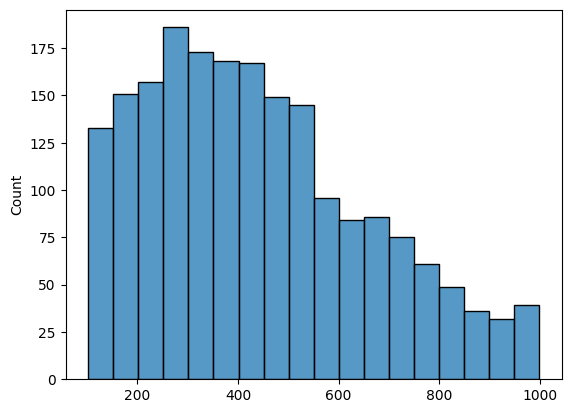

In [9]:
len_list = []
for s in dl:
    len_list.append(len(s))
sns.histplot(len_list)

p = 0
n = 0
for labels in ll:
    found_pos = False
    for l in labels:
        if l:
            p += 1
            found_pos = True
            break
    if not found_pos:
        n+=1
print(f'{p = }\n{n = }')

# Train model multiple labels

In [11]:
model = MultiClassifierCNN1D(num_classes=5, conv_channels=256, use_bias=True)
model.apply(init_weights)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
model

MultiClassifierCNN1D(
  (embedding): Embedding(21, 21)
  (conv1): Sequential(
    (0): Conv1d(21, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveMaxPool1d(output_size=1)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1,

In [14]:
trainer = TrainerMultipleClasses(model, loss_fn, optimizer, device)
df = trainer.train(epochs=50, train_iter=traindataloader, test_iter=testdataloader)

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-6-1a27aa51fb67>:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=1.1920 | test-loss=1.1838 | train-acc=0.4854 | test-acc=0.4060 | P=0.1438 | R=0.5181 | F1=0.2251
[epoch 01] train-loss=1.1665 | test-loss=1.1852 | train-acc=0.4055 | test-acc=0.4060 | P=0.1438 | R=0.5181 | F1=0.2251
[epoch 02] train-loss=1.1685 | test-loss=1.1838 | train-acc=0.4878 | test-acc=0.4060 | P=0.1438 | R=0.5181 | F1=0.2251
[epoch 03] train-loss=1.1643 | test-loss=1.1831 | train-acc=0.4173 | test-acc=0.5572 | P=0.1547 | R=0.3716 | F1=0.2185
[epoch 04] train-loss=1.1660 | test-loss=1.1844 | train-acc=0.5163 | test-acc=0.4196 | P=0.1551 | R=0.5589 | F1=0.2429
[epoch 05] train-loss=1.1647 | test-loss=1.1842 | train-acc=0.4210 | test-acc=0.5572 | P=0.1547 | R=0.3716 | F1=0.2185
[epoch 06] train-loss=1.1691 | test-loss=1.1840 | train-acc=0.4653 | test-acc=0.4553 | P=0.1849 | R=0.6662 | F1=0.2895
[epoch 07] train-loss=1.1669 | test-loss=1.1838 | train-acc=0.5508 | test-acc=0.4181 | P=0.1539 | R=0.5544 | F1=0.2409
[epoch 08] train-loss=1.1670 | test-loss=1.1853 

In [15]:
df.to_csv('multi-label_classifier.csv')